# House Prices Prediction

# Imports

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import ensemble, tree
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline


# Getting Data

In [3]:


train_predictors = pd.read_csv('train.csv')
test_predictors = pd.read_csv('test.csv')
print("train : " + str(train_predictors.shape))
print("test : " + str(test_predictors.shape))

train : (1460, 81)
test : (1459, 80)


# Get Correlations

In [4]:


correlations = train_predictors.corr()
correlations = correlations["SalePrice"].sort_values(ascending=False)
correlations

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

# Drop Target variable from Train Data set

In [5]:

train_target = train_predictors['SalePrice']
#train_predictors = train.drop(['SalePrice'],axis=1)

# Drop Id column from train and test data sets

In [6]:
train_ID = train_predictors['Id']
test_ID = test_predictors['Id']

In [7]:

train_predictors.drop("Id", axis = 1, inplace = True)
test_predictors.drop("Id", axis = 1, inplace = True)

In [8]:
test_predictors.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


**Pre Processing**

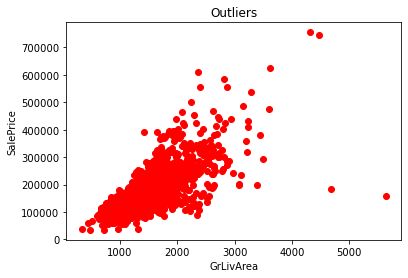

In [9]:
plt.scatter(train_predictors.GrLivArea, train_predictors.SalePrice, c= 'red')
plt.title("Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()



In [10]:
train_predictors = train_predictors[train_predictors.GrLivArea < 4000]

# Check for skewness in Target Variable

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

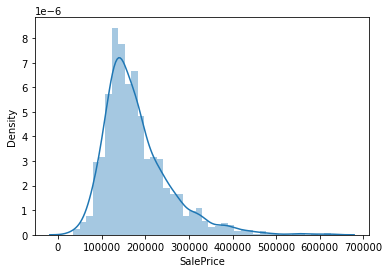

In [11]:
train_target = train_predictors['SalePrice']
sns.distplot(train_target)

It is Right skewed

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

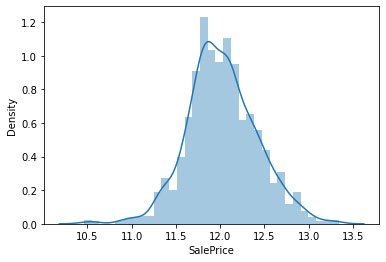

In [12]:
sns.distplot(np.log(train_target))
#Applying log will reduce the effect of Cheap and expensive houses on the models

In [13]:
train_target_final = np.log(train_target)

# Dealing with Missing Values

In [14]:
train_predictors_missing = pd.isna(train_predictors).sum()
test_missing = pd.isna(test_predictors).sum()

missing = pd.concat([train_predictors_missing, test_missing], axis=1, keys=["Train", "Test"])


missing_values = missing[missing.sum(axis=1) > 0]  #Missing Values
missing_values

,Train,Test
MSZoning,0,4.0
LotFrontage,259,227.0
Alley,1365,1352.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,8,16.0
MasVnrArea,8,15.0
BsmtQual,37,44.0
BsmtCond,37,45.0


Missing values which has some meaning

For example If PoolQC variable is missing that indicates that there is no Pool in th House, We should not remove these types of variables even though they are missing

In [15]:
#There are some features which are categorical and whose missing values are meaningful these we can know by looking Description of Data

meaningful_missing = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", 
                    "GarageCond", "Fence","PoolQC", "MiscFeature"]

In [16]:
for i in meaningful_missing:
    train_predictors[i].fillna("None", inplace=True)
    test_predictors[i].fillna("None", inplace=True)

In [17]:
train_predictors.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,1,2008,WD,Normal,118000


Missing Values with no explaination for those Missing values

In [18]:
train_missing1 = pd.isna(train_predictors).sum()
test_missing1 = pd.isna(test_predictors).sum()

missing1 = pd.concat([train_missing1, test_missing1], axis=1, keys=["Train", "Test"])


missing1_values = missing1[missing1.sum(axis=1) > 0]  #Missing Values
missing1_values

,Train,Test
MSZoning,0,4.0
LotFrontage,259,227.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,8,16.0
MasVnrArea,8,15.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtUnfSF,0,1.0


In [19]:
#LotFrontage which is Numeric value has many missing values so we remove it
train_predictors.drop("LotFrontage", axis=1, inplace=True)
test_predictors.drop("LotFrontage", axis=1, inplace=True)

In [20]:
train_predictors.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

In [21]:
test_predictors.shape

(1459, 78)

In [22]:
train_predictors.shape

(1456, 79)

Separate Numeric and Categorical features in the train and test data sets

In [23]:
numeric_features_train = train_predictors.select_dtypes(include=[np.number])

numeric_features_test = test_predictors.select_dtypes(include=[np.number])

In [24]:
numeric_features_train.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [25]:
numeric_features_test.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [26]:
# There are some Numerical features in the data set which are actually categorical, 
#They are MSSubClass and MoSold (Month sold)
#we need to convert them into categorical
train_predictors = train_predictors.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

test_predictors = test_predictors.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [27]:
#Drop Target variable from Train Data set
train_predictors = train_predictors.drop(['SalePrice'],axis=1)

In [28]:
numeric_features_train = train_predictors.select_dtypes(include=[np.number])

numeric_features_test = test_predictors.select_dtypes(include=[np.number])

In [29]:
categorical_features_train = train_predictors.select_dtypes(include=[object])

categorical_features_test = test_predictors.select_dtypes(include=[object])

In [30]:
numeric_features_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'],
      dtype='object')

In [31]:
numeric_features_train.fillna(numeric_features_train.mean(),inplace=True)
numeric_features_test.fillna(numeric_features_test.mean(),inplace=True)

In [32]:
numeric_features_train.shape

(1456, 33)

In [33]:
numeric_features_test.shape

(1459, 33)

In [34]:
categorical_features_train.fillna(categorical_features_train.mode(), inplace = True)
categorical_features_test.fillna(categorical_features_test.mode(), inplace = True)

In [35]:
categorical_features_train.shape

(1456, 45)

In [36]:
categorical_features_test.shape

(1459, 45)

In [37]:
#Combining Categorical features of both train and test sets for Encoding
categorical_features_traintest = pd.concat([categorical_features_train , categorical_features_test])

In [38]:
ntrain = categorical_features_train.shape[0]
ntrain

1456

In [39]:
categorical_features_traintest.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

Encoding Categorical features

In [40]:
#BackwardDifference Encoder
import category_encoders as ce
encoder = ce.BackwardDifferenceEncoder(cols=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'])
categorical_encoded = encoder.fit_transform(categorical_features_traintest)

categorical_encoded.head()

,intercept,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,...,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,1,-0.9375,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
1,1,0.0625,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
2,1,-0.9375,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
3,1,0.0625,0.125,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,0.166667,-0.666667,-0.5,-0.333333,-0.166667
4,1,-0.9375,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667


In [41]:
#Separating Categorical features of Train and test data sets after encoding
categorical_train_encoded = categorical_encoded[:ntrain]
categorical_test_encoded = categorical_encoded[ntrain:]

In [42]:
final_train = pd.concat([numeric_features_train, categorical_train_encoded],axis=1)
final_test = pd.concat([numeric_features_test, categorical_test_encoded],axis=1)

In [43]:
final_train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,8450,7,5,2003,2003,196.0,706,0,150,856,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
1,9600,6,8,1976,1976,0.0,978,0,284,1262,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
2,11250,7,5,2001,2002,162.0,486,0,434,920,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
3,9550,7,5,1915,1970,0.0,216,0,540,756,...,-0.5,-0.4,-0.3,-0.2,-0.1,0.166667,-0.666667,-0.5,-0.333333,-0.166667
4,14260,8,5,2000,2000,350.0,655,0,490,1145,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667


In [44]:
final_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_4', 'SaleType_5', 'SaleType_6', 'SaleType_7', 'SaleType_8',
       'SaleCondition_0', 'SaleCondition_1', 'SaleCondition_2',
       'SaleCondition_3', 'SaleCondition_4'],
      dtype='object', length=291)

In [45]:
final_test.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_4', 'SaleType_5', 'SaleType_6', 'SaleType_7', 'SaleType_8',
       'SaleCondition_0', 'SaleCondition_1', 'SaleCondition_2',
       'SaleCondition_3', 'SaleCondition_4'],
      dtype='object', length=291)

# Feature Engineering

In [46]:
#Adding new features to train and test data
# Overall quality of the house
# Total number of bathrooms
final_train["TotalBath"] = final_train["BsmtFullBath"] + (0.5 * final_train["BsmtHalfBath"]) + \
final_train["FullBath"] + (0.5 * final_train["HalfBath"])

final_test["TotalBath"] = final_test["BsmtFullBath"] + (0.5 * final_test["BsmtHalfBath"]) + \
final_test["FullBath"] + (0.5 * final_test["HalfBath"])

# Total SF for house (incl. basement)
final_train["AllSF"] = final_train["GrLivArea"] + final_train["TotalBsmtSF"]

final_test["AllSF"] = final_test["GrLivArea"] + final_test["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
final_train["AllFlrsSF"] = final_train["1stFlrSF"] + final_train["2ndFlrSF"]

final_test["AllFlrsSF"] = final_test["1stFlrSF"] + final_test["2ndFlrSF"]

# Total SF for porch
final_train["AllPorchSF"] = final_train["OpenPorchSF"] + final_train["EnclosedPorch"] + \
final_train["3SsnPorch"] + final_train["ScreenPorch"]

final_test["AllPorchSF"] = final_test["OpenPorchSF"] + final_test["EnclosedPorch"] + \
final_test["3SsnPorch"] + final_test["ScreenPorch"]

In [47]:
final_train.shape

(1456, 295)

In [48]:
final_test.shape

(1459, 295)

# Modeling

In [49]:
# Partition the dataset in train + validation sets
from sklearn.model_selection import train_test_split #to create validation data set
X_train, X_test, y_train, y_test = train_test_split(final_train, train_target_final, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 295)
X_test : (437, 295)
y_train : (1019,)
y_test : (437,)


 Linear Regression without regularization

In [50]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [51]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [52]:
mse_train = np.mean((y_train_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lm.score(X_test,y_test))

MSE on Training set :  0.007327081149123877
MSE on Test set :  0.016879783213044272
0.8920723516191188


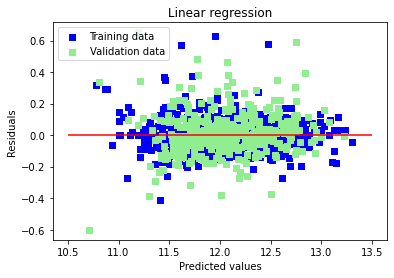

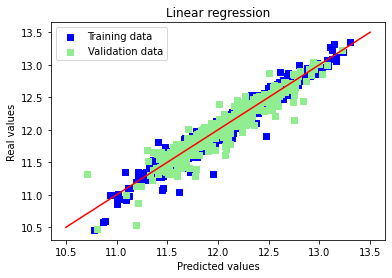

In [53]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Linear Regression with Ridge regularization (L2 Penalty)

In [54]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 30, 40, 50, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 20.0


In [55]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-15, 1.e-10, 1.e-08, 1.e-04, 1.e-03, 1.e-02, 1.e+00, 5.e+00,
       1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01]))

In [56]:
y_train_ridge_pred = ridge.predict(X_train)
y_test_ridge_pred = ridge.predict(X_test)

In [57]:
mse_train = np.mean((y_train_ridge_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_ridge_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(ridge.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  0.009933557749274294
MSE on Test set :  0.012115359563774289
0.9225356006944146


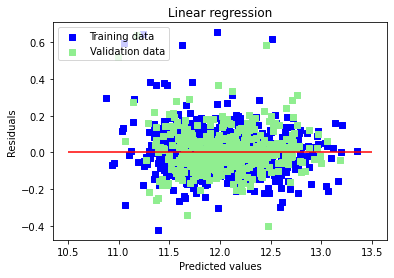

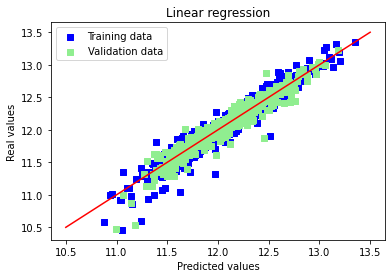

In [58]:
# Plot residuals
plt.scatter(y_train_ridge_pred, y_train_ridge_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test_ridge_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_ridge_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()



Linear Regression with Lasso regularization (L1 Penalty)

# LINEARREGRESSION

In [59]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [60]:
reg=LinearRegression()

In [61]:
reg.fit(X_train,y_train)

LinearRegression()

In [62]:
reg.coef_

array([ 3.85303237e-06,  3.47366846e-02,  3.47145316e-02,  1.57095269e-03,
        9.13731099e-04,  4.30898014e-05,  2.82968525e-05,  6.01609737e-06,
       -1.34503771e-05,  2.08626207e-05,  5.74396485e-05,  3.10356369e-06,
        1.17266831e-08,  6.05549408e-05,  3.03834320e-03,  2.12581961e-02,
        4.35669796e-03,  2.06504326e-02,  7.38329847e-03, -2.27985479e-02,
        9.82798784e-04,  1.20570585e-02, -3.86260797e-04,  3.93659155e-03,
        1.61200445e-04,  1.06576332e-04, -8.16894340e-05, -3.91021062e-05,
        7.55945393e-05,  1.45564106e-04, -6.53972070e-05,  1.84582441e-07,
       -3.04610948e-03,  1.62925229e-14, -1.83182647e-02,  2.73124596e-02,
       -1.06502633e-02,  7.40154245e-02, -3.44782725e-01,  2.07049766e-01,
        7.83380654e-03, -2.45366301e-02,  1.40796496e-01, -1.01235146e-01,
       -9.13216704e-02,  1.51839563e-01, -8.36756857e-03, -1.16080068e-01,
        3.81361609e-14, -5.15686089e-02, -3.18056352e-01,  4.26895012e-01,
       -5.99350226e-02,  

In [63]:
reg.intercept_

12.394718735670601

In [64]:
y_pred=reg.predict(X_test)
y_pred

array([12.24182876, 12.50936636, 12.80373228, 12.50672222, 12.55008338,
       12.31246626, 12.99911354, 12.02727402, 11.91260932, 11.74314986,
       12.74929867, 12.67979425, 12.240608  , 12.35317169, 12.23293534,
       12.15632501, 11.91189103, 12.41064185, 11.53196502, 12.73539342,
       12.06006577, 11.93393503, 11.45524707, 11.85661433, 12.56136382,
       11.94654594, 12.08192124, 11.888114  , 12.63169416, 12.50211976,
       12.17698573, 12.07164255, 12.18941013, 12.07580648, 12.53542003,
       11.59313827, 11.80361462, 11.0954481 , 11.93758446, 11.91472872,
       12.23626787, 11.87035081, 12.07374404, 11.93109823, 12.27684638,
       12.03883383, 11.44423748, 11.87795941, 11.54069582, 12.04516132,
       11.92498503, 12.40462677, 12.57808991, 12.08587759, 11.90783719,
       11.63160252, 12.47453237, 12.66195033, 11.89969937, 11.53499145,
       11.71596938, 12.09847464, 11.74313947, 11.84462756, 12.0729374 ,
       12.1463342 , 11.81702222, 11.97068433, 11.42758147, 12.48

In [65]:
y_test

511     12.219310
963     12.384219
231     12.906692
688     12.879017
34      12.533576
          ...    
416     11.915052
745     12.610871
1392    11.719940
461     11.951180
566     12.691580
Name: SalePrice, Length: 437, dtype: float64

In [66]:
reg.score(X_test,y_test)

0.8920723516191188

# MSE AND RMSE

In [67]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [68]:
mse=mean_squared_error(y_test,y_pred)

print("MSE",mse)

MSE 0.01687978321304426


In [69]:
rmse=np.sqrt(mse)

print("RMSE",rmse)

RMSE 0.12992221985882269


# SVM

In [70]:
from sklearn.svm import SVR

In [71]:
sr=SVR()
sr.fit(X_train,y_train)


SVR()

In [72]:
sr_pred=sr.predict(X_test)
sr_pred

array([12.01222568, 12.38836868, 12.79327087, 12.17640223, 12.31191005,
       12.28626079, 12.83264515, 11.99383041, 11.91215265, 11.74281261,
       12.50914815, 12.62167539, 12.30752408, 12.46105059, 12.2005991 ,
       12.10818294, 11.91772581, 12.37426086, 11.82548579, 12.59315381,
       11.95362469, 11.88721654, 11.64648846, 11.71022246, 12.47486255,
       11.7909933 , 12.15478198, 11.85692539, 12.66292502, 12.61624483,
       12.02257437, 11.93654115, 12.31721998, 12.03365557, 12.12138697,
       11.66613012, 11.78544878, 11.30953387, 12.13969934, 11.79132031,
       12.31512517, 11.73129231, 12.34043631, 11.99434097, 12.20935892,
       11.97628011, 11.53454026, 11.83996285, 11.825686  , 11.89454016,
       11.71036862, 12.23949068, 12.53895713, 12.0321911 , 11.76844256,
       11.69041751, 12.25722896, 12.69380442, 11.79002469, 11.85257699,
       11.79516958, 12.01097079, 11.87997095, 11.72361188, 12.23842661,
       12.16993502, 11.80240562, 12.02093946, 11.91130696, 12.46

# MEAN SQUARED ERROR

In [73]:
mse=mean_squared_error(y_test,sr_pred)

In [74]:
print("mse",mse)

mse 0.036550590355969644


# RMSE

In [75]:
rmse=np.sqrt(mse)
print("rmse",rmse)

rmse 0.19118208691184863


# MAE

In [76]:
from sklearn.metrics import mean_absolute_error

mae= mean_absolute_error(y_test,sr_pred)

print("mae",mae)


mae 0.1395247338146615


# MEAN ABSOLUTE PERCENTAGE ERROR

In [81]:
import numpy as np

def mean_absolute_percentage_error(y_test,sr_pred):
    y_test,sr_pred=np.array(y_test),np.array(sr_pred)*100
    return np.mean(np.abs((y_test - sr_pred)/y_test))
mean_absolute_percentage_error(y_test,sr_pred)

0.011667151540523859